# Descriptor-Based ML
An example of approaches used to do machine learning with chemical descriptors. 

We are going to use [Mordred](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y#Sec1), a Python library that wraps RDKit and other codes so that they work better with the Python data and ML libraries.

In [88]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from mordred import Calculator, descriptors
from rdkit import Chem
import pandas as pd
import numpy as np


## Load in the Dataset
We are going to use a copy of the [QM9 dataset](https://www.nr2_scorecom/articles/sdata201422) for this example

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True).sample(1000)  # Do not need the full set to make a point.
print(f'Loaded {len(data)} molecules')

Loaded 1000 molecules


Parse as RDKit molecule objects

In [3]:
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)

## Descriptor Calculators with Modred
The key unit for working with Mordred is the [``Calculator``](http://mordred-descriptor.github.io/documentation/master/mordred.html#mordred.Calculator) object.

In [4]:
calc = Calculator(descriptors, ignore_3D=True)

Modred has a lot of descriptors, and we are going to use quite a few of them to demonstrate some points about machine learning. 

In [5]:
print(f'First 10 out of {len(calc.descriptors)} descriptors')
calc.descriptors[:10]

First 10 out of 1613 descriptors


(mordred.ABCIndex.ABCIndex(),
 mordred.ABCIndex.ABCGGIndex(),
 mordred.AcidBase.AcidicGroupCount(),
 mordred.AcidBase.BasicGroupCount(),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMax'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpDiam'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('SpMAD'),
 mordred.AdjacencyMatrix.AdjacencyMatrix('LogEE'))

Modred also lets you compute these descriptors in parallel (using Python's [multiprocessing](https://docs.python.org/3/library/multiprocessing.html)) and stores them in a Pandas dataframe.

*NOTE*: This takes about 6 minutes on my desktop computer. If it takes too long, just turn down the number of molecules sampled in cell 2.

In [6]:
desc = calc.pandas(data['mol'])

100%|███████████████████████████████████████| 1000/1000 [04:51<00:00,  3.43it/s]


In [7]:
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

Computed 1613 descriptors for 1000 molecules


## Preprocessing
The main issue before using all of these features for machine learning, especially on small datasets, is the need to perform feature selection.

There are few issues to be concerned about. 

For one, some of the descriptors are the same for all molecules.

In [8]:
zero_variation = [c for c, s in desc.std().items() if s == 0]

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [9]:
print(f'{len(zero_variation)} ({len(zero_variation) / len(desc.columns) *100:.1f}%) features are constant for the dataset. Examples: {zero_variation[:5]}')

198 (12.3%) features are constant for the dataset. Examples: ['nB', 'nS', 'nP', 'nCl', 'nBr']


Many of these features may be improtant for some datasets but not ours. For example, our dataset contains only C, H, N, O and F so the number of boron atoms is not needed.

We can safely drop these columns

In [2]:
desc.drop(columns=zero_variation, inplace=True)
print(f'New shape: {desc.shape}')

NameError: name 'desc' is not defined

Next, we are going to convert all of the values to numbers. It just makes things easier

In [11]:
for c in desc.columns:
    desc[c] = pd.to_numeric(desc[c], errors='coerce')

Then, we look for features that have missing values. 

*Dev Note*: We use the [`isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) and [`any`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.any.html) functions from Pandas to check if any rows of each column have a null value. In many cases, you can write complex loops in Pandas as simple efficient statements. So, if you start writing a loop over a column maybe check the Pandas docs for an example before getting too far.

In [12]:
missing_values = desc.isnull().any()
print(f'Found {missing_values.sum()} columns with missing values')

Found 387 columns with missing values


In [13]:
desc = desc.loc[:, ~missing_values]  # Gets only columns that do not (~ means not) have missing values
print(f'New shape: {desc.shape}')

New shape: (1000, 1028)


## Testings Components a Model Pipeline
The data require a few more transformations before we can use them in a machine learning model

### Adjust Features to the Same Scale
First, we need to scale the data. If we randomly select a few columns, you will see that they vary wildly in values

In [14]:
desc.sample(8, axis=1).describe()

,AATS4p,GATS1m,AMID_C,AATS1s,VSA_EState5,nHRing,AATSC4m,NaaaC
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.909157,0.863638,1.434753,3.207923,0.968365,0.982000,-4.984947,0.011000
std,0.152040,0.164189,0.274010,0.912939,1.589473,0.882301,8.188360,0.144568
min,0.395807,0.449505,0.547670,1.600000,-2.312500,0.000000,-38.016730,0.000000
25%,0.815400,0.750397,1.273692,2.526791,0.000000,0.000000,-9.520728,0.000000
50%,0.901840,0.849097,1.463444,3.060560,0.439236,1.000000,-4.721601,0.000000
75%,0.989257,0.969559,1.610294,3.722222,1.465278,1.000000,0.175707,0.000000
max,1.781128,1.444444,2.251479,7.527778,10.666667,5.000000,38.230613,2.000000


There are many ways to scale it. We are going to use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to adjust so that the mean is zero and the standard deviation is 1.

In [15]:
scaler = StandardScaler()
feats = scaler.fit_transform(desc)

This "scaler" object holds on to the means and scales of each feature so that we can then apply them to new data. You'll see where this is useful later.

In [16]:
scaler.mean_[:8], scaler.scale_[:8]

(array([6.71704700e+00, 6.82397600e+00, 7.00000000e-03, 2.91000000e-01,
        1.08920638e+01, 2.42767765e+00, 4.62777699e+00, 1.08920638e+01]),
 array([0.76030933, 0.74780865, 0.10464703, 0.59859753, 0.98154039,
        0.2374076 , 0.39342869, 0.98154039]))

In [17]:
feats[:, :8].mean(axis=0), feats[:, :8].std(axis=0)

(array([ 5.61328761e-16, -7.54951657e-16, -2.22044605e-17, -1.77635684e-17,
        -1.46549439e-16, -5.22248911e-16,  1.35713663e-15, -1.27009514e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

### Compress Features
Many of the features in the dataset are strongly correlated with each other. For larger datasets, the subtle differences between different features could be helpful in building models. For smaller datasets, the strong correlations could lead to overfitting (e.g., some algorithms will learn preferrentially from the signals that are overrepresented in the model)

In [18]:
cross_corr = np.corrcoef(feats.T)  # Feats.T is the transpose, which allows us to easily compute the correlation between descriptors

Text(0.5, 0, 'Descriptor ID')

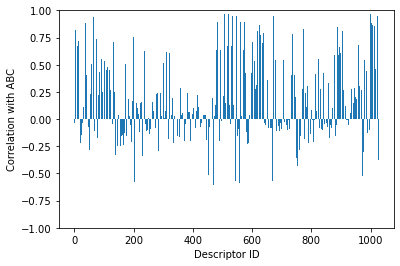

In [19]:
fig, ax = plt.subplots()

ax.bar(range(len(cross_corr)-1), cross_corr[0, 1:])

ax.set_ylim(-1, 1)
ax.set_ylabel(f'Correlation with {desc.columns[0]}')
ax.set_xlabel('Descriptor ID')

Note how many of the features are correlated strongly with each other.

There are [numerous ways](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) to compress a set of features to a smaller set of the features that contain roughly the same information. We will use [Principle Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for its relative simplicity

In [20]:
pca = PCA().fit(feats)

PCA creates a new set of features that are linear combinations of the descriptors. One of the best things about PCA is that it can also show how how much of the data is explained by the new features.

Text(0, 0.5, 'Explained Variance')

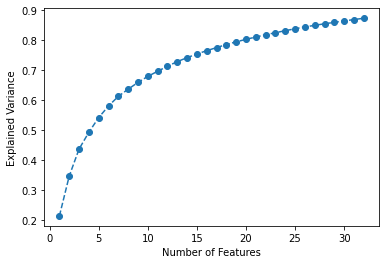

In [21]:
fig, ax = plt.subplots()

num_features = 32
ax.plot(1 + np.arange(num_features),
           np.cumsum(pca.explained_variance_ratio_)[:num_features], 'o--')

ax.set_xlabel('Number of Features')
ax.set_ylabel('Explained Variance')

Note that as we increase the number of features, we start to gradually explain more of the data.

Let's pick 16 features for now to illustrate the new features

In [1]:
pca.n_components = 16
pca_feats = pca.fit_transform(feats)

NameError: name 'pca' is not defined

These are all mutually orthogonal

In [23]:
cross_corr = np.corrcoef(pca_feats.T)
print(f'The largest correlation between feature 0 and all others is {max(cross_corr[0, 1:]):.2e}')

The largest correlation between feature 0 and all others is 2.30e-17


### Select Features
The last issue is that not all of the features are correlated well with the target variable. 

In [24]:
feat_score = [np.corrcoef(data['bandgap'], f)[0][1] for f in pca_feats.T]

Text(0.5, 0, 'Feature ID')

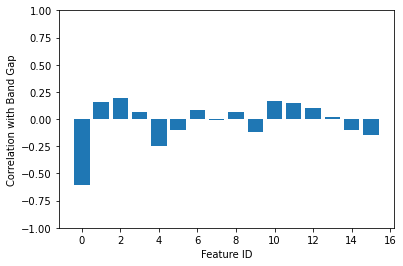

In [25]:
fig, ax = plt.subplots()

ax.bar(range(len(feat_score)), feat_score)

ax.set_ylim(-1, 1)
ax.set_ylabel(f'Correlation with Band Gap')
ax.set_xlabel('Feature ID')

This last portion means that we need to consider even more feature selection to select only those features which are relevant to the problem being modeled.

For that, we are going to use [LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso) - a linear regression model that automatically includes only the most important features. The penalty used to determine how many features are used, $\alpha$, must be set by experimenting with different values. Scikit-Learn has the [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) class that automatically select the best $\alpha$ for you using cross-validation.

In [26]:
lasso = LassoCV().fit(pca_feats, data['bandgap'])

Text(0.5, 0, 'Feature ID')

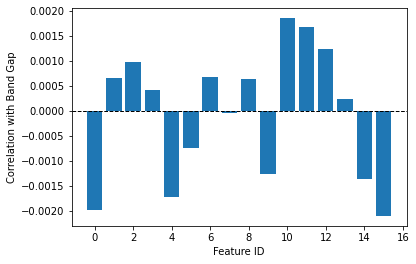

In [27]:
fig, ax = plt.subplots()

ax.bar(range(len(feat_score)), lasso.coef_)
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1.)

ax.set_ylabel(f'Correlation with Band Gap')
ax.set_xlabel('Feature ID')

Depending on your configuration for this notebook, you may notice some of the coefficients are 0.

## Putting it Together
Scikit-Learn includes a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) function to make it easier to train models that contain multiple steps. It is a fantastic tool to become familiar with because, as we will demonstrate, it makes experimenting with model settings easier.

Step 1: Make a holdout-set. Not that I split both the data and the descriptors at the same time, which means the same rows (i.e., molecules) get partitioned from each array. `train_data[0]` is the same record as `train_desc[0]`

In [89]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, test_size=0.1)

In [90]:
train_desc

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
8779,7.723905,7.878257,0,1,11.615198,2.707662,5.217976,11.615198,1.290578,3.348773,...,10.367001,62.863863,124.063663,7.297863,78,9,60.0,80.0,2.395833,1.777778
22572,5.766244,6.027282,0,0,10.472136,2.000000,4.000000,10.472136,1.163571,3.007971,...,7.739359,34.994205,128.083730,6.099225,110,7,32.0,31.0,4.361111,2.416667
10244,6.432911,6.454586,0,0,10.796691,2.288246,4.576491,10.796691,1.199632,3.109446,...,9.001962,38.370040,118.078250,6.214645,100,7,40.0,44.0,3.472222,2.194444
20290,6.302351,7.270943,0,1,11.278503,2.519914,4.570932,11.278503,1.253167,3.180780,...,9.372374,59.406478,120.068748,7.062868,89,10,44.0,54.0,4.173611,2.291667
24254,6.473351,6.191587,0,0,11.142106,2.200122,4.400244,11.142106,1.238012,3.089776,...,8.606851,37.313444,126.042927,8.402862,88,9,40.0,43.0,3.472222,2.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,7.057238,7.482955,0,0,11.293771,2.671726,4.966565,11.293771,1.254863,3.273091,...,10.030164,62.234591,122.073165,6.424903,86,8,52.0,67.0,3.284722,2.000000
5103,7.685364,7.633718,0,1,12.386741,2.653932,4.945719,12.386741,1.376305,3.372350,...,10.030693,63.733546,127.063329,7.059074,82,9,58.0,76.0,2.305556,1.805556
23399,7.828530,8.074563,0,1,11.148155,2.833740,5.497187,11.148155,1.238684,3.384376,...,10.853464,64.452744,125.084064,6.254203,76,9,64.0,89.0,3.097222,1.687500
24325,6.084081,6.128166,0,0,8.947017,2.311302,4.414525,8.947017,1.118377,3.006038,...,8.782169,50.541414,116.047344,7.252959,58,6,40.0,43.0,3.923611,1.666667


In [91]:
train_data['bandgap']

8779     0.2555
22572    0.2878
10244    0.2247
20290    0.2590
24254    0.1691
          ...  
7368     0.2980
5103     0.2891
23399    0.3036
24325    0.3320
24245    0.2785
Name: bandgap, Length: 900, dtype: float64

In [92]:
clf = RandomForestRegressor()

In [94]:
clf.fit(train_desc, train_data['bandgap'])

RandomForestRegressor()

In [95]:
test_data = test_data.copy()

In [96]:
test_data['RF_model']= clf.predict(test_desc)

Step 2: Make a hold-out set

In [99]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV())
])

In [100]:
test_data = test_data.copy()  # Avoids some pandas issues
test_data['Lasso_without_PCA'] = model.fit(train_desc, train_data['bandgap']).predict(test_desc)

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004198948116748008, tolerance: 0.00017475521964444447
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046683766642655056, tolerance: 0.00017475521964444447
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006491526018999327, tolerance: 0.00017475521964444447
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_

/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003842743693008299, tolerance: 0.00016801917488750004
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020866885302192606, tolerance: 0.00016801917488750004
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020017817318863929, tolerance: 0.00016801917488750004
  positive)
/Users/wueric/opt/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear

In [97]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('randomforest', RandomForestRegressor())
])

In [98]:
test_data = test_data.copy()  # Avoids some pandas issues
test_data['Random_forest_model'] = model.fit(train_desc, train_data['bandgap']).predict(test_desc)

Now, let's show how to change the PCA from 16 to only 8 features.

In [52]:
model.set_params(pca__n_components=8)  # Notation is [step name]__[parameter name]

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=8)),
                ('lasso', LassoCV())])

In [33]:
test_data['8-ncomp-model'] = model.fit(train_desc, train_data['bandgap']).predict(test_desc)

Compare the two to each other

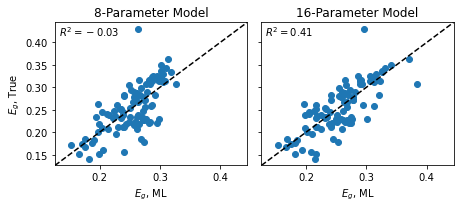

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 3.))

# Plot both models
for ax, col in zip(axs, ['8-ncomp-model', '16-ncomp-model']):
    ax.set_title(f'{col.split("-")[0]}-Parameter Model')
    r2 = r2_score(test_data[col], test_data['bandgap'])
    ax.text(0.02, 0.9, f'$R^2 = {r2:.2f}$', transform=ax.transAxes)
    ax.scatter(test_data[col], test_data['bandgap'])

# Make it look nicer
for ax in axs:
    ax.set_xlabel('$E_g$, ML')
    
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    
axs[0].set_ylabel('$E_g$, True')
fig.tight_layout()

You can see that you get a better model with adding additional parameters.

In [101]:
test_data

,A,B,C,R2,alpha,atomic_charges,bandgap,cv,filename,g,...,u,u0,u0_atom,xyz,zpe,in_holdout,mol,RF_model,Random_forest_model,Lasso_without_PCA
19292,5.73680,1.37641,1.31188,906.0150,60.16,"[-0.287116, 0.284385, -0.270485, 0.155184, -0....",0.2559,22.559,dsgdb9nsd_021347.xyz,-373.741142,...,-373.702566,-373.709126,-1.985502,12\nProperties=species:S:1:pos:R:3 unique_id=2...,0.086345,False,<rdkit.Chem.rdchem.Mol object at 0x7fed94b8ebc0>,0.227333,0.225521,0.265633
20135,3.78678,0.99062,0.95676,1314.6968,73.71,"[-0.31837699999999997, -0.291788, -0.076149, -...",0.2127,31.772,dsgdb9nsd_128087.xyz,-435.292585,...,-435.248780,-435.257772,-2.705293,18\nProperties=species:S:1:pos:R:3 unique_id=1...,0.147896,False,<rdkit.Chem.rdchem.Mol object at 0x7fed94b543f0>,0.224920,0.228354,0.229104
15844,2.96869,1.58237,1.19493,1082.9525,80.09,"[-0.33535000000000004, -0.100314, -0.117821, -...",0.2951,31.398,dsgdb9nsd_081547.xyz,-403.079255,...,-403.038708,-403.046737,-2.967890,20\nProperties=species:S:1:pos:R:3 unique_id=c...,0.171097,False,<rdkit.Chem.rdchem.Mol object at 0x7fed75fda8f0>,0.294256,0.293277,0.292695
21868,3.06918,1.30055,0.91943,1224.2967,81.30,"[-0.49777499999999997, 0.130361, -0.164911, -0...",0.2074,32.108,dsgdb9nsd_132506.xyz,-426.083771,...,-426.042573,-426.050942,-2.818763,17\nProperties=species:S:1:pos:R:3 unique_id=c...,0.136276,False,<rdkit.Chem.rdchem.Mol object at 0x7fed8849d3f0>,0.195551,0.196784,0.213757
7719,2.30211,1.42235,0.93615,1268.2842,76.53,"[-0.340754, -0.390986, 0.38514699999999996, 0....",0.2195,32.942,dsgdb9nsd_128146.xyz,-431.460456,...,-431.416347,-431.425639,-2.616789,18\nProperties=species:S:1:pos:R:3 unique_id=7...,0.149140,True,<rdkit.Chem.rdchem.Mol object at 0x7fed75fb3f80>,0.223624,0.222505,0.222460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4772,2.16049,1.38339,1.13158,1147.6787,69.42,"[-0.430556, -0.11299000000000001, 0.121943, -0...",0.2973,34.919,dsgdb9nsd_099925.xyz,-458.921294,...,-458.877420,-458.886869,-2.610316,17\nProperties=species:S:1:pos:R:3 unique_id=b...,0.132783,True,<rdkit.Chem.rdchem.Mol object at 0x7fed76047850>,0.277226,0.277700,0.272285
15750,5.26465,0.84328,0.82097,1398.4890,76.34,"[-0.32778199999999996, 0.27106199999999997, -0...",0.3114,30.667,dsgdb9nsd_035131.xyz,-401.963417,...,-401.921252,-401.929610,-2.851309,18\nProperties=species:S:1:pos:R:3 unique_id=8...,0.148123,False,<rdkit.Chem.rdchem.Mol object at 0x7fed75ffdcb0>,0.287525,0.289406,0.299857
4498,4.17495,0.77076,0.65811,1631.8224,73.62,"[-0.43310000000000004, -0.07747699999999999, 0...",0.2359,35.403,dsgdb9nsd_099013.xyz,-472.437268,...,-472.391857,-472.401713,-2.631427,18\nProperties=species:S:1:pos:R:3 unique_id=e...,0.147057,True,<rdkit.Chem.rdchem.Mol object at 0x7fed75fb3300>,0.226837,0.225217,0.241060
316,2.57551,1.19417,0.96646,1381.5442,94.21,"[-0.393065, -0.19408399999999998, 0.0025889999...",0.2635,37.606,dsgdb9nsd_112117.xyz,-352.417802,...,-352.374183,-352.383809,-3.758493,25\nProperties=species:S:1:pos:R:3 unique_id=a...,0.230227,True,<rdkit.Chem.rdchem.Mol object at 0x7fed75fda940>,0.252807,0.253150,0.276427


In [ ]:
plt.bar([10, 100, 1000, 10000],[])